# Bank Marketing Prediction

## Objectives

The goal is to predict if the client, who received marketing phone calls, will subscribe to a bank service (term deposit). 

Besides developing a classification model to predict if a client will subscribe to the service, I want to analyze how effective was the campaign and what type of client was more likely to subscribe.

I am using the [Bank Marketing Dataset](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) from the UCI Machine Learning Repository

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

## Loading data

In [2]:
#Loading train dataset
bank=pd.read_csv('bank-full.csv',  sep=';')
#bank=pd.read_csv('bank.csv')

In [3]:
# Checking the dataset

print("\n Bank dataset dimensions", bank.shape)
print("\n Columns info", bank.info())


 Bank dataset dimensions (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

 Columns info None


In [4]:
#Taking a look at the dataset
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Wrangling & Exploration

<strong> y: target variable - </strong> Has the client subscribed to a term deposit? yes/no

In [5]:
#Checking how many customers have subscribed to the service
bank.groupby('y').size()

y
no     39922
yes     5289
dtype: int64

There are two things that I'll have to work on here. First, I'll have to recode 'yes' and 'no' to numbers because the algorithms won't read the way it is now. Also, the categories are pretty unbalanced. I'll have to balance the dataset before modelling.  

In [6]:
#Taking a look at the proportion of the categories
no_sub= len(bank[bank['y']=='no'])
do_sub= len(bank[bank['y']=='yes'])
pc_sub= do_sub/(do_sub + no_sub)
print("share of clients subscribing to the service:", round(pc_sub*100, 2))
pc_no_sub= no_sub/(do_sub + no_sub)
print("share of clients not subscribing to the service:", round(pc_no_sub*100, 2))

share of clients subscribing to the service: 11.7
share of clients not subscribing to the service: 88.3


In [7]:
#Changing labels

#creating a dictionary to change labels:
y_labels={"y":{"yes":1,"no":0}}

#changing the columns in the dataset and taking a look
bank.replace(y_labels, inplace=True)

#Transforming to categorical type
bank['y'] = bank['y'].astype("category")

<strong> Client data </strong>

<strong> Age </strong>

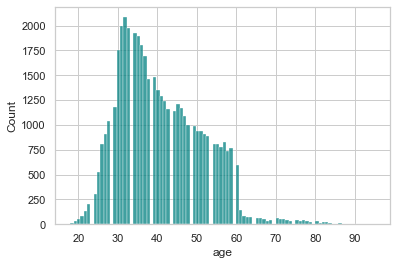

In [8]:
#checking the distribution of the variable
sns.histplot(data=bank, x="age", color='teal')

Most clients are between 30-40 and 40-50 years of age. How about those who subscribed to the service?

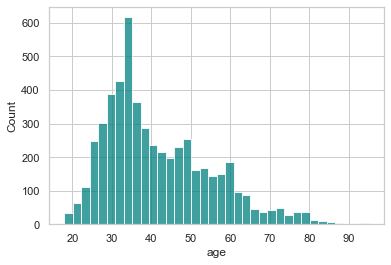

In [9]:
#distribution when y=1
bank_y=bank[bank['y']==1]
sns.histplot(data=bank_y, x="age", color='teal')

They are mostly on their late 20s and between 30-40 years of age

<strong> Job </strong>

In [10]:
#Defining function to create count graphs
def count_graph(data,column):
    sns.catplot(y=column, data=data, kind="count", color='darkturquoise',
           order = data[column].value_counts().index)

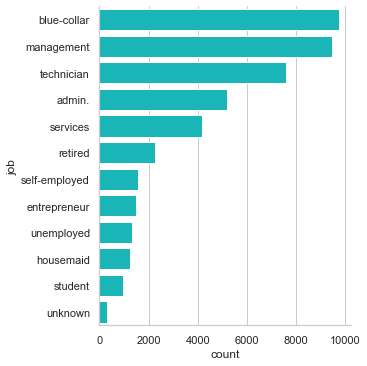

In [11]:
#Count
count_graph(bank,'job')

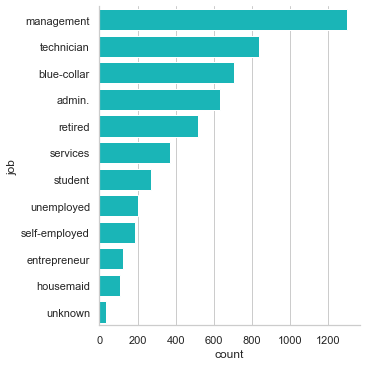

In [12]:
# Count of clients who got the service
count_graph(bank_y,'job')

It's interesting to see that despite having more blue-collar workers in the dataset, managers and technicians are the ones who subscribe more to the service.

<strong> Marital </strong>

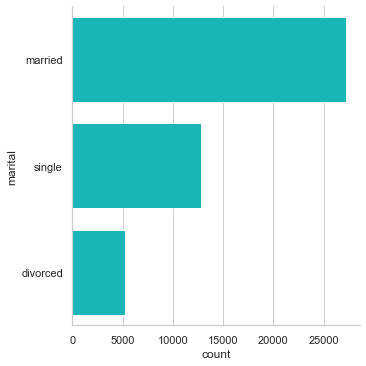

In [13]:
count_graph(bank,'marital')

<strong> Education </strong>

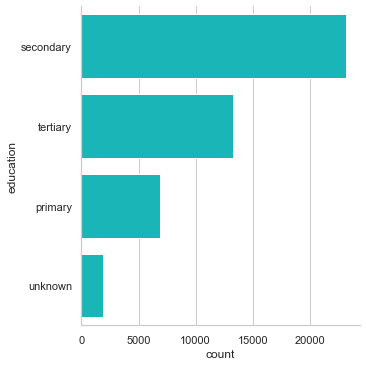

In [14]:
count_graph(bank,'education')

Most clients in the dataset are married and has secondary education (which was expected since most of them are blue-collars)

In [15]:
#One-hot enconding variables job, marital and education
bank=pd.get_dummies(bank,columns=['job','marital','education'])